In [72]:
# Importando Blibliotecas
import pandas as pd
import numpy as np

In [73]:
# Lendo dataset
db_prep = pd.read_excel('/content/db_teste.xlsx')

# Configuração para exibir todas as colunas do dataset
pd.set_option('display.max_columns', None)

In [74]:
# Visualizando o dataset
db_prep.head(n=5)

,mes_referencia,primeiraadesaoid,clienteid,adesaoid,transacaoid,documento,valor_minimo,data_transacao,valor,saldo,saldoanterior,tipooperacaoid,data_cadastro_cliente,cidade,estado,total_adesao_ativa,valor_mensalidade_paga,ultima_data_pagamento,total_uso_pedagio,valor_gasto_pedagio,total_uso_estacionamento,valor_gasto_estacionamento
0,2023-01-01,4726479,1701078,4726479,653740433.0,34466072850,30,2022-09-23 05:27:51.087,-17.90,-12.80,5.10,23.0,2021-08-20 12:59:20,Louveira,São Paulo,0,NaN,2022-09-23 05:27:51.087,0,NaN,0,NaN
1,2023-01-01,4441794,1615386,4505132,729301193.0,36956140802,30,2023-01-22 11:08:28.927,-4.70,55.58,60.28,7.0,2021-03-24 14:36:29,São Paulo,São Paulo,1,0.00,2023-01-26 05:28:48.29,13,59.1,1,22.0
2,2023-01-01,3369428,1228697,3369428,726339748.0,30194319806,50,2023-01-18 05:08:04.497,-22.23,45.44,67.67,23.0,2019-07-18 19:07:27,São Paulo,São Paulo,0,22.23,2023-01-18 05:08:04.497,0,NaN,0,NaN
3,2023-01-01,6511684,56535,6642809,733768464.0,34365646800,150,2023-01-28 17:58:00.433,-11.00,74.11,85.11,14.0,2013-10-11 06:07:59,São Bernardo do Campo,São Paulo,1,20.90,2023-01-15 06:32:16.833,3,23.4,1,11.0
4,2023-01-01,3988094,1460739,4351209,488311092.0,2453086790,50,2021-09-05 09:46:04.180,-3.90,58.40,62.30,7.0,2021-07-14 13:35:57,Serra,Espírito Santo,0,0.00,2023-01-09 05:56:59.527,0,NaN,0,NaN


In [71]:
del db_prep

In [98]:
# Tratando valores NaN das colunas de valores
tratando_valores_nan = ['valor_gasto_estacionamento',
                        'valor_gasto_pedagio',
                        'valor_mensalidade_paga']
db_prep[tratando_valores_nan] = db_prep[tratando_valores_nan].fillna(0)
# Removendo as demais linhas NaN do dataset
db_prep = db_prep.dropna()

db_prep['valor'] = db_prep['valor'].abs()
db_prep['saldo_negativo'] = np.where(db_prep['saldo'] <= 0, 1, 0)

def categorizar_uso(row):
    if row['total_uso_pedagio'] > 0 and row['total_uso_estacionamento'] > 0:
        return 'pedagio_e_estacionamento'
    elif row['total_uso_pedagio'] > 0 and row['total_uso_estacionamento'] == 0:
        return 'pedagio'
    elif row['total_uso_pedagio'] == 0 and row['total_uso_estacionamento'] > 0:
        return 'estacionamento'
    else:
        return 'sem uso'
db_prep['faixa_uso'] = db_prep.apply(categorizar_uso, axis=1)

def mapear_tipo_operacao(row):
    if pd.notna(row['tipooperacaoid']):
        if row['tipooperacaoid'] == 23:
            return 'mensalidade'
        elif row['tipooperacaoid'] == 7:
            return 'pedagio'
        elif row['tipooperacaoid'] == 14:
            return 'estacionamento'
    return 'outros'

db_prep['tipo_transacao'] = db_prep.apply(mapear_tipo_operacao, axis=1)

# Preparando Dataset Para Treino

In [158]:
db_model = db_prep[['documento',
                    'valor',
                    'valor_mensalidade_paga',
                    'faixa_uso',
                    'tipo_transacao',
                    'saldo_negativo']]

# Encoding

In [159]:
df_encoded = pd.get_dummies(db_model, columns=['faixa_uso',
                                               'tipo_transacao'])

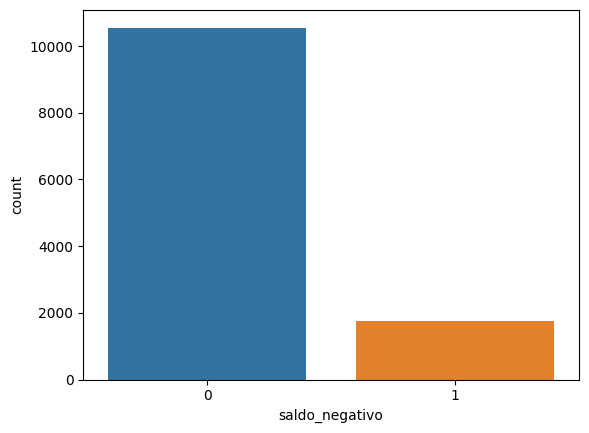

In [160]:
import seaborn as sns
%matplotlib inline

ax = sns.countplot(x='saldo_negativo', data=df_encoded)

In [161]:
# Para podermos aplicar o SMOTE, devemos separar  os dados em variáveis características e resposta

X = df_encoded.drop('saldo_negativo', axis = 1)
y = df_encoded['saldo_negativo']

In [162]:
from imblearn.over_sampling import SMOTE

smt = SMOTE(random_state=123)  # Instancia um objeto da classe SMOTE
X, y = smt.fit_resample(X, y)  # Realiza a reamostragem do conjunto de dados

In [163]:
df_encoded = pd.concat([X, y], axis=1)  # Concatena a variável target (y) com as features (X)

# Verifica se o balanceamento e a concatenação estão corretos.
df_encoded.head(n=2)

,documento,valor,valor_mensalidade_paga,faixa_uso_estacionamento,faixa_uso_pedagio,faixa_uso_pedagio_e_estacionamento,faixa_uso_sem uso,tipo_transacao_estacionamento,tipo_transacao_mensalidade,tipo_transacao_outros,tipo_transacao_pedagio,saldo_negativo
0,34466072850,17.9,0.0,0,0,0,1,0,1,0,0,1
1,36956140802,4.7,0.0,0,0,1,0,0,0,0,1,0


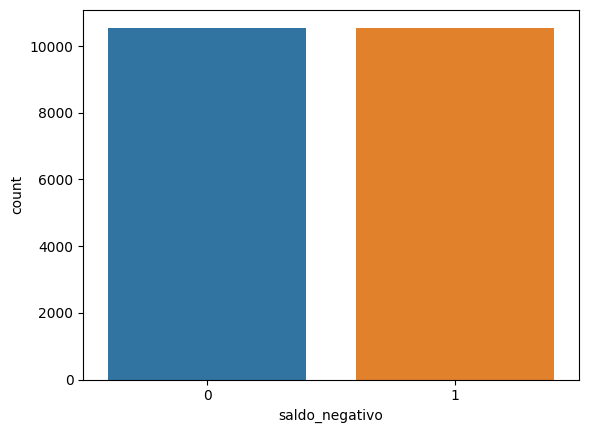

In [164]:

ax = sns.countplot(x='saldo_negativo', data=df_encoded)  # plotando a variável target balanceada.

# Preparando Dataset Para Ser Treinado

In [165]:
# Divisão em entradas e saídas (inputs e outputs)
x = df_encoded.drop('saldo_negativo',axis = 1)
y = df_encoded['saldo_negativo']

In [157]:
x

,documento,valor,saldo,valor_mensalidade_paga,faixa_uso_estacionamento,faixa_uso_pedagio,faixa_uso_pedagio_e_estacionamento,faixa_uso_sem uso,tipo_transacao_estacionamento,tipo_transacao_mensalidade,tipo_transacao_outros,tipo_transacao_pedagio
0,34466072850,17.900000,-12.800000,0.000000,0,0,0,1,0,1,0,0
1,36956140802,4.700000,55.580000,0.000000,0,0,1,0,0,0,0,1
2,30194319806,22.230000,45.440000,22.230000,0,0,0,1,0,1,0,0
3,34365646800,11.000000,74.110000,20.900000,0,0,1,0,1,0,0,0
4,2453086790,3.900000,58.400000,0.000000,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
21101,44416621800,16.532688,-10.832561,15.401396,0,0,0,1,0,1,0,0
21102,30008863165,19.113346,-30.458969,19.113346,0,0,0,1,0,1,0,0
21103,7259011560,16.341551,-13.973572,12.196614,0,0,0,0,0,0,0,0
21104,32252188369,14.881126,-2.425683,0.000000,0,0,0,1,0,1,0,0


In [166]:
# Biblioteca para padronizar os dados
from sklearn.preprocessing import StandardScaler

In [167]:
norm = StandardScaler()

x_normalizado = norm.fit_transform(x)
x_normalizado

array([[ 0.29633846, -0.0277291 , -0.86251214, ...,  1.14629868,
        -0.35167551, -0.53479925],
       [ 0.40006855, -0.5474571 , -0.86251214, ..., -0.87237299,
        -0.35167551,  1.86986052],
       [ 0.11838775,  0.14275743,  1.67525056, ...,  1.14629868,
        -0.35167551, -0.53479925],
       ...,
       [-0.83704069, -0.08909045,  0.52984562, ..., -0.87237299,
        -0.35167551, -0.53479925],
       [ 0.20411348, -0.14659223, -0.86251214, ...,  1.14629868,
        -0.35167551, -0.53479925],
       [-0.43145767,  0.0903909 , -0.86251214, ...,  1.14629868,
        -0.35167551, -0.53479925]])

In [168]:
x_normalizado[0]

array([ 0.29633846, -0.0277291 , -0.86251214, -0.20143448, -0.45302395,
       -0.40752589,  0.9480003 , -0.26264612,  1.14629868, -0.35167551,
       -0.53479925])

In [169]:
# Importando biblioteca para treino e teste
from sklearn.model_selection import train_test_split

In [170]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x_normalizado,y,test_size= 0.3, random_state= 123)

In [171]:
# Importando a biblioteca para criar o modelo de machine learning
from sklearn.neighbors import KNeighborsClassifier

In [172]:
# Instanciar o modelo (criamos o modelo) por padrão são 5 vizinhos
knn = KNeighborsClassifier(metric= 'euclidean')

In [173]:
# Treine o modelo com seus dados de treinamento
knn.fit(x_treino, y_treino)

KNeighborsClassifier(metric='euclidean')

In [174]:
# Treinando o modelo com os dados de teste
predito_knn = knn.predict(x_teste)

In [175]:
# Biblioteca para criarmos o modelo de machine learning
from sklearn.naive_bayes import BernoulliNB

In [176]:
# Escolhi utilizar mediana porque é o valor central dos nossos dados ordenados
np.median(x_treino)

-0.35167550975921535

In [179]:
# Criamos o modelo
bnb = BernoulliNB(binarize=0.35)

In [180]:
bnb.fit(x_treino,y_treino)

BernoulliNB(binarize=0.35)

In [181]:
predito_bnb = bnb.predict(x_teste)

# Arvore de Decisão

In [182]:
# Importando a biblioteca para criação do modelo
from sklearn.tree import DecisionTreeClassifier

In [183]:
# Instanciando o modelo
dtc = DecisionTreeClassifier(criterion= 'entropy', random_state= 34)

In [184]:
# Treinanando o modelo
dtc.fit(x_treino,y_treino)

DecisionTreeClassifier(criterion='entropy', random_state=34)

In [185]:
predito_arvoreDecisao = dtc.predict(x_teste)

In [204]:
predito_arvoreDecisao

array([0, 0, 1, ..., 0, 1, 0])

# Validação dos Modelos

In [187]:
from sklearn.metrics import confusion_matrix

In [188]:
print(confusion_matrix(y_teste,predito_knn))

[[2961  169]
 [ 264 2938]]


In [189]:
print(confusion_matrix(y_teste,predito_bnb))

[[2531  599]
 [ 389 2813]]


In [190]:
print(confusion_matrix(y_teste,predito_arvoreDecisao))

[[2906  224]
 [ 230 2972]]


# Medindo a acuracia do Modelo

In [191]:
from sklearn.metrics import accuracy_score

In [192]:
# Modelo KNN
print(accuracy_score(y_teste,predito_knn))

0.9316171825647505


In [193]:
# Modelo Bernoulli de Naive Bayes
print(accuracy_score(y_teste,predito_bnb))

0.8439671509791535


In [194]:
# Modelo Árvore de decisão
print(accuracy_score(y_teste,predito_arvoreDecisao))

0.9283006948831333


# Calculando a precisão do Modelo

In [205]:
from sklearn.metrics import precision_score

In [206]:
# Modelo KNN
print(precision_score(y_teste,predito_knn))

0.9456066945606695


In [207]:
# Modelo Bernouli de Naive Bayes
print(precision_score(y_teste,predito_bnb))

0.8244431418522861


In [208]:
# Modelo Árvore de Decisão
print(precision_score(y_teste,predito_arvoreDecisao))

0.9299123904881101


# Recall

In [209]:
from sklearn.metrics import recall_score

In [210]:
# Modelo Knn
print(recall_score(y_teste,predito_knn))

0.9175515302935665


In [211]:
# Modelo Bernoulli de Naive Bayes
print(recall_score(y_teste,predito_bnb))

0.8785134291068083


In [212]:
# Modelo de Árvore de decisão
print(recall_score(y_teste,predito_arvoreDecisao))

0.9281698938163647


# Escolhendo o melhor modelo

In [214]:
# Escolhendo o melhor modelo
print('Modelo KNN: ', precision_score(y_teste,predito_knn))
print('==================================================')
print('Modelo BNB: ', precision_score(y_teste,predito_bnb))
print('==================================================')
print('Modelo Árvore de decisão: ', precision_score(y_teste,predito_arvoreDecisao))

Modelo KNN:  0.9456066945606695
Modelo BNB:  0.8244431418522861
Modelo Árvore de decisão:  0.9299123904881101
